In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


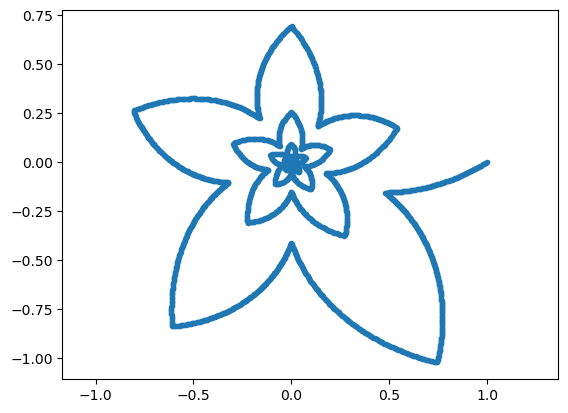

In [2]:
N = 2048
t = np.linspace(1/N, 1, N)
a = 2.0*np.pi*np.log(t)
r = t * (1.0+0.3*np.arcsin(np.sin(5.0*a)))
p = np.array([r*np.cos(a), r*np.sin(a)]).T

plt.plot(p[:, 0], p[:, 1], '.')
plt.axis('equal')
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, ni, nh, no):
        super(Model, self).__init__()

        self.activation = torch.sin
        self.layer1 = nn.Linear(ni, nh)
        self.layer2 = nn.Linear(nh, nh)
        self.layer3 = nn.Linear(nh, nh)
        self.layer4 = nn.Linear(nh, nh)
        self.layer5 = nn.Linear(nh, nh)
        self.layer6 = nn.Linear(nh, no)

    def forward(self, x):
        xm = self.activation(self.layer1(x))
        xm = self.activation(self.layer2(xm))+xm
        xm = self.activation(self.layer3(xm))+xm
        xm = self.activation(self.layer4(xm))+xm
        xm = self.activation(self.layer5(xm))+xm
        return self.layer6(xm)

NZ = 16
NH = 32
ND = 2

encoder = Model(ND, NH, NZ).to(device)
decoder = Model(NZ, NH, ND).to(device)

print(encoder)
print(decoder)

Model(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=16, bias=True)
)
Model(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=2, bias=True)
)


In [4]:
def chamfer_distance(pc1, pc2):
    # Calculate pairwise distances
    pairwise_distances_pc1_pc2 = torch.cdist(pc1, pc2, p=2)
    pairwise_distances_pc2_pc1 = torch.cdist(pc2, pc1, p=2)

    # Find the nearest neighbors for each point
    nearest_neighbors_pc1 = torch.min(pairwise_distances_pc1_pc2, dim=1).values
    nearest_neighbors_pc2 = torch.min(pairwise_distances_pc2_pc1, dim=1).values

    # Calculate the Chamfer distance
    chamfer_loss = torch.mean(nearest_neighbors_pc1) + torch.mean(nearest_neighbors_pc2)

    return chamfer_loss


data = torch.tensor(p, dtype=torch.float32, device=device)

optimizer_e = torch.optim.Adam(
    encoder.parameters(),
    lr=0.002
)
optimizer_d = torch.optim.Adam(
    decoder.parameters(),
    lr=0.002
)

soboleng = torch.quasirandom.SobolEngine(dimension=NZ)

def rand_lds(n):
    u = soboleng.draw(n).to(device)
    return torch.erfinv(1.9999*(u-0.5))


batch_size = 1024

for batch_i in range(100000):
    i = torch.arange(0, batch_size, dtype=torch.int64, device=device)
    i = ((i + batch_i*batch_size) * 131407079) % len(data)

    x = data[i]
    z = encoder(x)
    y = decoder(z)
    # loss_diff = 0.5 * torch.mean(torch.abs(y-x))
    loss_diff = torch.mean((y-x)**2)
    # loss_diff = 0.5 * loss_diff + 0.2 * loss_diff ** 0.5
    # loss_diff = 0.5 * torch.mean((y-x)**2) ** 0.5

    z = rand_lds(batch_size)
    y = decoder(z)
    loss_vae = 1.0 * chamfer_distance(y, x)

    loss = loss_diff + loss_vae

    encoder.zero_grad()
    decoder.zero_grad()
    loss.backward()
    optimizer_e.step()
    optimizer_d.step()

    if (batch_i+1) % 1000 == 0:
        print('%d diff %.4f, vae %.4f, total %.4f' % (
            batch_i+1, loss_diff.item(), loss_vae.item(), loss.item()))


1000 diff 0.0020, vae 0.0710, total 0.0730
2000 diff 0.0007, vae 0.0525, total 0.0532
3000 diff 0.0005, vae 0.0404, total 0.0408
4000 diff 0.0003, vae 0.0341, total 0.0344
5000 diff 0.0003, vae 0.0327, total 0.0329
6000 diff 0.0001, vae 0.0319, total 0.0320
7000 diff 0.0002, vae 0.0286, total 0.0288
8000 diff 0.0001, vae 0.0268, total 0.0269
9000 diff 0.0001, vae 0.0262, total 0.0263
10000 diff 0.0002, vae 0.0283, total 0.0285
11000 diff 0.0002, vae 0.0255, total 0.0257
12000 diff 0.0001, vae 0.0232, total 0.0233
13000 diff 0.0001, vae 0.0236, total 0.0237
14000 diff 0.0001, vae 0.0247, total 0.0248
15000 diff 0.0001, vae 0.0231, total 0.0233
16000 diff 0.0002, vae 0.0212, total 0.0214
17000 diff 0.0001, vae 0.0224, total 0.0225
18000 diff 0.0001, vae 0.0217, total 0.0218
19000 diff 0.0001, vae 0.0205, total 0.0205
20000 diff 0.0001, vae 0.0212, total 0.0213
21000 diff 0.0001, vae 0.0188, total 0.0189
22000 diff 0.0001, vae 0.0197, total 0.0198
23000 diff 0.0001, vae 0.0210, total 0.02

(2048, 2)


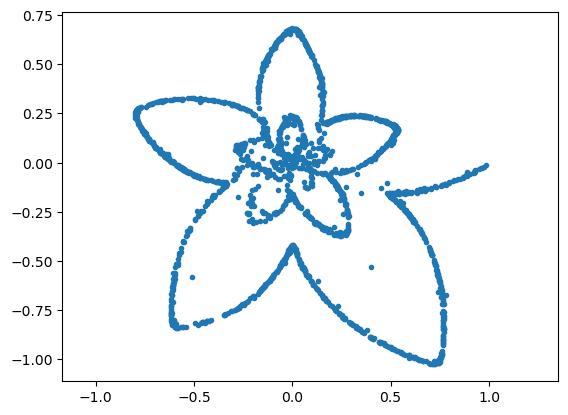

In [9]:
z = rand_lds(2*batch_size)

with torch.no_grad():
    y = decoder(z)

y = y.detach().cpu().numpy()
print(y.shape)

plt.plot(y[:, 0], y[:, 1], '.')
plt.axis('equal')
plt.show()